# Data APIs and pandas operations


Several of the notebooks we've already explored loaded datasets into a python pandas dataframe for analysis. Local copies of some of these datasets had been previously saved to disk in a few cases we read in the data directly from an online sources via a data API. This section explains how that is done in a bit more depth.  Some of the possible advantages of reading in the data this way is that it allows would-be users to modify and extend the analysis, perhaps focusing on different time-periods or adding in other variables of interest.  

Easy to use python wrappers for data APIs have been written for the World Bank and several other online data providers (including FRED, Eurostat, and many many others). The [pandas-datareader](http://pandas-datareader.readthedocs.org/) library allows access to several databases from the [World Bank's datasets](http://data.worldbank.org/) and other sources.  


If you haven't already installed the pandas-datareader library you can do so directly from a jupyter notebook code cell:

```!pip install pandas-datareader```

Once the library is in installed we can load it as:

In [1]:
%matplotlib inline
import seaborn as sns
import warnings
import numpy as np
import statsmodels.formula.api as smf
import datetime as dt

In [2]:
from pandas_datareader import wb

### Data on urban bias

Our earlier analysis of the Harris_Todaro migration model suggested that policies designed to favor certain sectors or labor groups 

Let's search for indicators (and their identification codes) relating to GDP per capita and urban population share.  We could look these up in a book or from the website http://data.worldbank.org/ but we can also search for keywords directly.

First lets search for series having to do with gdp per capita

In [3]:
wb.search('gdp.*capita.*const')[['id','name']]

,id,name
685,6.0.GDPpc_constant,"GDP per capita, PPP (constant 2011 internation..."
7588,NY.GDP.PCAP.KD,GDP per capita (constant 2010 US$)
7590,NY.GDP.PCAP.KN,GDP per capita (constant LCU)
7592,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 internation..."


We will use NY.GDP.PCAP.KD for GDP per capita (constant 2010 US$).

You can also first browse and search for data series from the World Bank's DataBank page at http://databank.worldbank.org/data/.  Then find the 'id' for the series that you are interested in in the 'metadata' section from the webpage

Now let's look for data on urban population share:

In [4]:
wb.search('Urban Population')[['id','name']].tail()

,id,name
9999,SP.URB.GROW,Urban population growth (annual %)
10000,SP.URB.TOTL,Urban population
10001,SP.URB.TOTL.FE.ZS,"Urban population, female (% of total)"
10002,SP.URB.TOTL.IN.ZS,Urban population (% of total)
10003,SP.URB.TOTL.MA.ZS,"Urban population, male (% of total)"


Let's use the ones we like but use a python dictionary to rename these to shorter variable names when we load the data into a python dataframe:

In [5]:
indicators = ['NY.GDP.PCAP.KD', 'SP.URB.TOTL.IN.ZS']

Since we are interested in exploring the extent of 'urban bias' in some countries, let's load data from 1980 which was toward the end of the era of import-substituting industrialization when urban-biased policies were claimed to be most pronounced.

In [6]:
dat = wb.download(indicator=indicators, country = 'all', start=1980, end=1980)

In [7]:
dat.columns

Index(['NY.GDP.PCAP.KD', 'SP.URB.TOTL.IN.ZS'], dtype='object')

Let's rename the columns to something shorter and then plot and regress log gdp per capita against urban extent we get a pretty tight fit:

In [8]:
dat.columns = [['gdppc', 'urbpct']]
dat['lngpc']  = np.log(dat.gdppc)

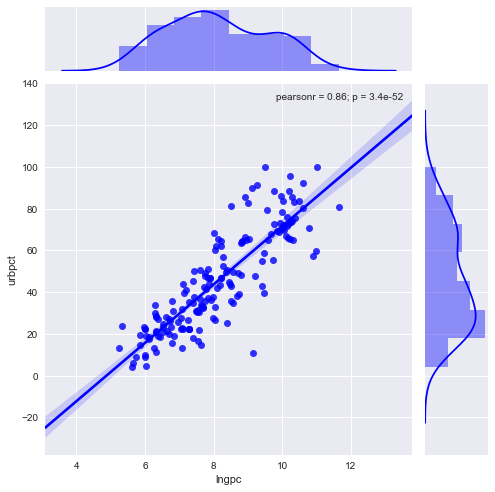

In [9]:
g = sns.jointplot("lngpc", "urbpct", data=dat, kind="reg",
                  color ="b", size=7)

That is a pretty tight fit: urbanization rises with income per-capita, but there are several middle income country outliersthat have considerably higher urbanization than would be predicted.  Let's look at the regression line.

In [10]:
mod = smf.ols("urbpct ~ lngpc", dat).fit()

In [11]:
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 urbpct   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     494.3
Date:                Wed, 03 May 2017   Prob (F-statistic):           3.43e-52
Time:                        15:26:52   Log-Likelihood:                -670.94
No. Observations:                 172   AIC:                             1346.
Df Residuals:                     170   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -68.0209      5.185    -13.120      0.0

Now let's just look at a list of countries sorted by the size of their residuals in this regression line.  Countries with the largest residuals had urbanization in excess of what the model predicts from their 1980 level of income per capita.

Here is the sorted list of top 15 outliers. 

In [12]:
mod.resid.sort_values(ascending=False).head(15)

country               year
Singapore             1980    35.469714
Chile                 1980    30.563014
Malta                 1980    30.448467
Hong Kong SAR, China  1980    29.957702
Uruguay               1980    29.143223
Argentina             1980    25.369855
Cuba                  1980    24.148529
Belgium               1980    20.731859
Israel                1980    20.456625
Iraq                  1980    20.262678
Peru                  1980    17.810693
Myanmar               1980    17.719561
Bulgaria              1980    17.360914
Jordan                1980    15.706878
Colombia              1980    15.258744
dtype: float64

This is of course only suggestive but (leaving aside the island states like Singapore and Hong-Kong) the list is dominated by southern cone countries such as Chile, Argentina and Peru which in addition to having legacies of heavy political centralization also pursued ISI policies in the 60s and 70s that many would associate with urban biased policies. 

## Panel data

Very often we want data on several indicators and a whole group of countries over a number of years.  we could also have used datetime format dates: 

In [13]:
countries = ['CHL', 'USA', 'ARG']
start, end = dt.datetime(1950, 1, 1), dt.datetime(2016, 1, 1)
dat = wb.download(
    indicator=indicators, 
    country = countries, 
    start=start, 
    end=end).dropna()

Lets use shorter column names

In [14]:
dat.columns

Index(['NY.GDP.PCAP.KD', 'SP.URB.TOTL.IN.ZS'], dtype='object')

In [15]:
dat.columns = [['gdppc', 'urb']]

In [16]:
dat.head()

gdppc     urb
country   year                      
Argentina 2015  10501.660269  91.751
          2014  10334.780146  91.604
          2013  10711.229530  91.452
          2012  10558.265365  91.295
          2011  10780.342508  91.133

Notice this has a two-level multi-index.  The outer level is named 'country' and the inner level is 'year'

We can pull out group data for a single country like this using the `.xs` or cross section method.

In [17]:
dat.xs('Chile',level='country').head(3)

,gdppc,urb
year,,
2015,14660.505335,89.530
2014,14479.763258,89.356
2013,14364.140970,89.175


(Note we could have also used `dat.loc['Chile'].head()`)

And we can pull a 'year' level cross section like this: 

In [18]:
dat.xs('2007', level='year').head()

,gdppc,urb
country,,
Argentina,9830.759871,90.445
Chile,12223.484611,87.926
United States,49979.533843,80.269


Note that what was returned was a dataframe with the data just for our selected country.  We can in turn further specify what column(s) from this we want:

In [19]:
dat.loc['Chile']['gdppc'].head()

year
2015    14660.505335
2014    14479.763258
2013    14364.140970
2012    13963.665402
2011    13385.131216
Name: gdppc, dtype: float64

## Unstack data

The unstack method turns index values into column names while stack method converts column names to index values. Here we apply unstack.

In [20]:
datyr = dat.unstack(level='country')
datyr.head()

gdppc                                  urb          \
country    Argentina        Chile United States Argentina   Chile   
year                                                                
1960     5605.191722  3630.391789  17036.885170    73.611  67.836   
1961     5815.233002  3692.112435  17142.193767    74.217  68.660   
1962     5675.060043  3796.728684  17910.278790    74.767  69.435   
1963     5290.764999  3939.263166  18431.158404    75.309  70.200   
1964     5738.598474  3955.026738  19231.171859    75.844  70.955   

                       
country United States  
year                   
1960           69.996  
1961           70.377  
1962           70.757  
1963           71.134  
1964           71.508

We can now easily index a 2015 cross-section of GDP per capita like so:

In [21]:
datyr.xs('1962')['gdppc']

country
Argentina         5675.060043
Chile             3796.728684
United States    17910.278790
Name: 1962, dtype: float64

We'd get same result from `datyr.loc['2015']['gdppc']`

We can also easily plot all countries:

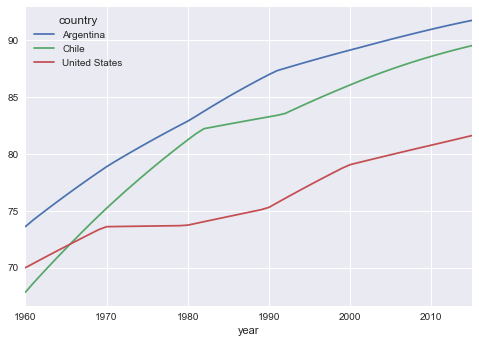

In [22]:
datyr['urb'].plot(kind='line');